In [159]:
import os
import pandas as pd
import numpy as np
from itables import show
from print_matrix import print_matrix
import matplotlib.pyplot as plt
from mortgage_calculator.utils_finance import add_growth

In [3]:
os.listdir("./data")

['state_market_tracker.tsv000',
 'neighborhood_market_tracker.tsv000',
 'zip_code_market_tracker.tsv000',
 '.gitignore',
 'us_national_market_tracker.tsv000',
 'redfin_metro_market_tracker.tsv000',
 'county_market_tracker.tsv000',
 'city_market_tracker.tsv000']

In [39]:
# read each table separated table in "./data" and print the number of rows
for file in os.listdir("./data"):
    df = pd.read_table("./data/" + file, sep="\t")
    print(file, df.shape[0])

state_market_tracker.tsv000 35171
neighborhood_market_tracker.tsv000 11880115
zip_code_market_tracker.tsv000 7705116
.gitignore 1
us_national_market_tracker.tsv000 1584
redfin_metro_market_tracker.tsv000 416926
county_market_tracker.tsv000 1018887
city_market_tracker.tsv000 5164217


In [90]:
df = pd.read_table("./data/city_market_tracker.tsv000", sep="\t")

In [91]:
print_matrix(sorted(df.columns), 4)

avg_sale_to_list                avg_sale_to_list_mom            avg_sale_to_list_yoy            city                            
homes_sold                      homes_sold_mom                  homes_sold_yoy                  inventory                       
inventory_mom                   inventory_yoy                   is_seasonally_adjusted          last_updated                    
median_dom                      median_dom_mom                  median_dom_yoy                  median_list_ppsf                
median_list_ppsf_mom            median_list_ppsf_yoy            median_list_price               median_list_price_mom           
median_list_price_yoy           median_ppsf                     median_ppsf_mom                 median_ppsf_yoy                 
median_sale_price               median_sale_price_mom           median_sale_price_yoy           months_of_supply                
months_of_supply_mom            months_of_supply_yoy            new_listings                    n

In [92]:
df["property_type"].value_counts()

property_type
All Residential              1986669
Single Family Residential    1951089
Condo/Co-op                   508323
Townhouse                     423089
Multi-Family (2-4 Unit)       295047
Name: count, dtype: int64

In [93]:
cols = [
    #"table_id",
    "parent_metro_region",
    "state_code",
    #"parent_metro_region_metro_code",
    "region_type",
    "region",
    "city",
    "period_begin",
    #"period_end",
    "last_updated",
    "property_type",
    #"median_dom",
    #"median_list_ppsf_mon",
    #"median_list_price_yoy",
    "median_sale_price",
    #"median_dom_mom",
    #"median_list_ppsf_yoy",
    "median_ppsf",
    #"median_sale_price_mom",
    #"median_dom_yoy",
    "median_list_price",
    #"median_ppsf_mom",
    "median_sale_price_yoy",
    "median_list_ppsf",
    #"median_list_price_mom",
    "median_ppsf_yoy",
]

In [217]:
# for each region, get cagr (10 years), last median sale price, and last median ppsf

def cagr(begining, ending, periods):
    return (ending / begining) ** (1 / periods) - 1


def munge_data(input_df):

    begin_year = 2013
    end_year = 2023
    ref_month = 12

    cols = [
        "parent_metro_region",
        "state_code",
        "region_type",
        "region",
        "period_begin",
        "last_updated",
        "property_type",
        "median_sale_price",
        "median_ppsf",
    ]

    # drop any rows where last_updated is before 2024
    input_df = input_df[input_df["last_updated"] >= "2024-01-01"]

    # restrict to just single family homes
    df = input_df.loc[(input_df["property_type"] == "Single Family Residential"), cols]

    # parse period begin as year and month
    df["period_begin"] = pd.to_datetime(df["period_begin"])
    df["period_begin_year"] = df["period_begin"].dt.year
    df["period_begin_month"] = df["period_begin"].dt.month

    # restrict to the last month of each year
    df = df[df["period_begin_month"] == ref_month]

    # drop unnecessary columns: period_begin_month, period_begin, last_updated, property_type
    df = df.drop(
        columns=["period_begin_month", "period_begin", "last_updated", "property_type"]
    )

    begin_year_df = df[df["period_begin_year"] == begin_year]
    end_year_df = df[df["period_begin_year"] == end_year]

    # merge begin and end year data
    df = pd.merge(
        begin_year_df,
        end_year_df,
        on=["parent_metro_region", "state_code", "region_type", "region"],
        suffixes=("_begin", "_end"),
    )

    df["median_sale_price_cagr"] = cagr(
        df["median_sale_price_begin"],
        df["median_sale_price_end"],
        end_year - begin_year,
    )

    df["median_ppsf_cagr"] = cagr(
        df["median_ppsf_begin"], df["median_ppsf_end"], end_year - begin_year
    )

    # drop median_sale_price_begin, median_ppsf_begin, period_begin_year_begin, period_begin_year_end
    df = df.drop(
        columns=[
            "median_sale_price_begin",
            "median_ppsf_begin",
            "period_begin_year_begin",
            "period_begin_year_end",
        ]
    )

    # rename columns
    df = df.rename(
        columns={
            "median_sale_price_end": "median_sale_price",
            "median_ppsf_end": "median_ppsf",
        }
    )

    return df
    

In [218]:
df1 = munge_data(df)

In [219]:
df1.head()

,parent_metro_region,state_code,region_type,region,median_sale_price,median_ppsf,median_sale_price_cagr,median_ppsf_cagr
0,"Washington, DC",VA,place,"Front Royal, VA",291000.0,176.404854,0.044935,0.045151
1,"Peoria, IL",IL,place,"Avon, IL",145000.0,66.270567,0.103818,0.081211
2,"Warren, MI",MI,place,"Marysville, MI",208000.0,180.555556,0.036739,0.068348
3,"New Orleans, LA",LA,place,"Gramercy, LA",169000.0,134.768740,0.038471,0.056466
4,"Detroit, MI",MI,place,"Northville, MI",515000.0,249.510763,0.048424,0.051372


In [220]:
df1.shape

(10179, 8)

In [222]:
df1.to_csv("../mortgage_calculator/data/city_housing_data.csv", index=False)

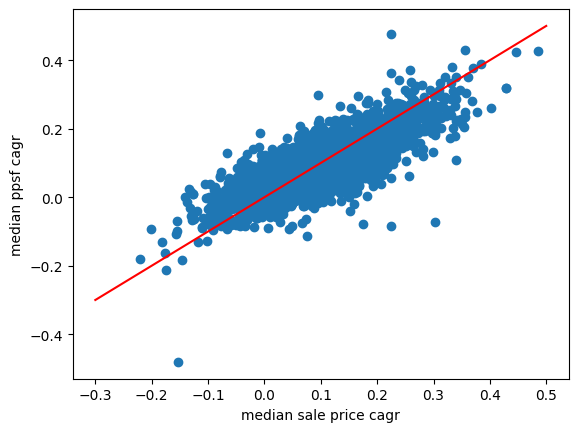

In [216]:
# plot median sale price cagr vs median ppsf cagr
plt.scatter(df1["median_sale_price_cagr"], df1["median_ppsf_cagr"])

plt.plot([-0.3, 0.5], [-0.3, 0.5], color="red")
plt.xlabel("median sale price cagr")
plt.ylabel("median ppsf cagr")
plt.show()
